In [1]:
import sys, os, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
sys.path.insert(0, os.path.join(parent_dir,'spring-break'))

In [2]:
import numpy as np
import random
from shutil import copyfile
import copy
import math
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from martins.complex_transformer import ComplexTransformer
from FNN import FNN
from FNNLinear import FNNLinear
from FNNSeparated import FNNSeparated
from powerfulGAN import Generator, Discriminator
from data_utils import *
import argparse
import logging
import logging.handlers
import pickle
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

from sklearn.manifold import TSNE
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

# DataLoader

In [3]:
class JoinDataset(Dataset):
    def __init__(self, source_x, source_y, target_x, target_y, random=False):
        self.source_x = source_x
        self.source_y = source_y
        self.target_x = target_x
        self.target_y = target_y
        
        self.source_len = self.source_y.shape[0]
        self.target_len = self.target_y.shape[0]
    
        self.random = random
    def __len__(self):
        return self.target_len
    
    def __getitem__(self, index):
        if self.random:
            index_source = random.randrange(self.source_len)
            index_target = random.randrange(self.target_len)
        else:
            index_source = index
            index_target = index

        return (self.source_x[index_source], self.source_y[index_source]), (self.target_x[index_target], self.target_y[index_target])
    
    
class SingleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = self.y.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


# Parser

In [4]:
# Parameters
parser = argparse.ArgumentParser(description='JDA Time series adaptation')
parser.add_argument("--data_path", type=str, default="../data_unzip/", help="dataset path")
parser.add_argument("--task", type=str, help='3A or 3E')
parser.add_argument('--batch_size', type=int, default=400, help='batch size')
parser.add_argument('--epochs', type=int, default=50, help='number of epochs')
parser.add_argument('--lr_gan', type=float, default=1e-3, help='learning rate for adversarial')
parser.add_argument('--lr_FNN', type=float, default=1e-3, help='learning rate for classification')
parser.add_argument('--lr_encoder', type=float, default=1e-3, help='learning rate for classification')
parser.add_argument('--n_critic', type=float, default=0.16, help='gap: Generator train GAP times, discriminator train once')
parser.add_argument('--target_lbl_percentage', type=float, default=0.7, help='percentage of target labeled data')
parser.add_argument('--source_lbl_percentage', type=float, default=0.7, help='percentage of source labeled data')
parser.add_argument('--num_per_class', type=int, default=2, help='number of sample per class when training local discriminator')
parser.add_argument('--seed', type=int, help='manual seed')
parser.add_argument('--save_path', type=str, default="../train_related/", help='where to store data')
parser.add_argument('--model_save_period', type=int, default=2, help='period in which the model is saved')
parser.add_argument('--gpweight', type=float, default=10, help='clip_value for WGAN')
parser.add_argument('--sclass', type=float, default=0.7, help='source domain classification weight on loss function')
parser.add_argument('--dlocal', type=float, default=0.01, help='local GAN weight on loss function')
parser.add_argument('--dglobal', type=float, default=0.01, help='global GAN weight on loss function')
parser.add_argument('--GANweights', type=int, default=-1, help='pretrained GAN weight')
parser.add_argument('--isglobal', type=int, default=0, help='if using global DNet')
parser.add_argument('--lr_centerloss', type=float, default=1e-3, help='center loss weight')
parser.add_argument('--pure_random', type=int, default=1, help='Pure random for n_critic')


args = parser.parse_args()
args.isglobal = True if args.isglobal == 1 else False
args.pure_random = True if args.pure_random == 1 else False

# snap shot of py file and command
python_file_name = sys.argv[0]


usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH] [--task TASK] [--batch_size BATCH_SIZE] [--epochs EPOCHS] [--lr_gan LR_GAN]
                             [--lr_FNN LR_FNN] [--lr_encoder LR_ENCODER] [--n_critic N_CRITIC] [--target_lbl_percentage TARGET_LBL_PERCENTAGE]
                             [--source_lbl_percentage SOURCE_LBL_PERCENTAGE] [--num_per_class NUM_PER_CLASS] [--seed SEED]
                             [--save_path SAVE_PATH] [--model_save_period MODEL_SAVE_PERIOD] [--gpweight GPWEIGHT] [--sclass SCLASS]
                             [--dlocal DLOCAL] [--dglobal DGLOBAL] [--GANweights GANWEIGHTS] [--isglobal ISGLOBAL]
                             [--lr_centerloss LR_CENTERLOSS] [--pure_random PURE_RANDOM]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/tianqinl/.local/share/jupyter/runtime/kernel-78b2b873-abf0-4c85-bdc5-db795b3c74fe.json


SystemExit: 2

/home/tianqinl/anaconda3/envs/russ-local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'data_path': '/home/tianqinl/Code/time-series-domain-adaptation/data_unzip',
    'task': '3E',
    'num_class': 50,
    'batch_size': 100,
    'num_per_class': 2,
    'gap': 5,
    'lbl_percentage':0.2,
    'lr_gan': 1e-4,
    'lr_FNN': 1e-4,
    'lr_encoder': 1e-4,
    'epochs': 2,
    'clip_value': 0.01,
    'n_critic': 0.16,
    'save_path': '/home/tianqinl/Code/time-series-domain-adaptation/train_related/',
    'target_lbl_percentage': 0.7,
    'source_lbl_percentage': 0.7,
    'lr_centerloss': 1e-3,
    'sclass': 0.7,
    'isglobal': True,
    'gpweight': 10,
    'dlocal': 1e-2,
    'model_save_period': 2,
    'pure_random': True,
})

In [6]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

# args.task = '3Av2' if args.task == '3A' else '3E'
# num_class = 50 if args.task == "3Av2" else 65
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# if args.num_per_class == -1:
#     args.num_per_class = math.ceil(args.batch_size / num_class)
    
# #model_sub_folder = 'Linear_GAN/lbl_percent_%f/task_%s_gpweight_%f_dlocal_%f_critic_%f_rand_%i_sclass_%f_global_%i'%(args.target_lbl_percentage, args.task, args.gpweight, args.dlocal, args.n_critic, args.pure_random, args.sclass, args.isglobal)

# save_folder = os.path.join(args.save_path, model_sub_folder)
# if not os.path.exists(save_folder):
#     os.makedirs(save_folder)   

# Logger

In [7]:
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

# if os.path.isfile(os.path.join(save_folder, 'logfile.log')):
#     os.remove(os.path.join(save_folder, 'logfile.log'))

# file_log_handler = logging.FileHandler(os.path.join(save_folder, 'logfile.log'))
# logger.addHandler(file_log_handler)

# stdout_log_handler = logging.StreamHandler(sys.stdout)
# logger.addHandler(stdout_log_handler)

# attrs = vars(args)
# for item in attrs.items():
#     logger.info("%s: %s"%item)
# logger.info('Saved in: {}'.format(save_folder))

In [8]:
# copyfile(python_file_name, os.path.join(save_folder, 'executed.py'))
# commands = ['python']
# commands.extend(sys.argv)
# with open(os.path.join(save_folder, 'command.log'), 'w') as f:
#     f.write(' '.join(commands))

# Data loading

In [9]:
args.task = '3Av2' if args.task == '3A' else '3E'
num_class = 50 if args.task == "3Av2" else 65

labeled_target_x_filename = '/processed_file_not_one_hot_%s_%1.1f_target_known_label_x.npy'%(args.task, args.target_lbl_percentage)
labeled_target_y_filename = '/processed_file_not_one_hot_%s_%1.1f_target_known_label_y.npy'%(args.task, args.target_lbl_percentage)
unlabeled_target_x_filename = '/processed_file_not_one_hot_%s_%1.1f_target_unknown_label_x.npy'%(args.task, args.target_lbl_percentage)
unlabeled_target_y_filename = '/processed_file_not_one_hot_%s_%1.1f_target_unknown_label_y.npy'%(args.task, args.target_lbl_percentage)
labeled_target_x = np.load(args.data_path+labeled_target_x_filename)
labeled_target_y = np.load(args.data_path+labeled_target_y_filename)
unlabeled_target_x = np.load(args.data_path+unlabeled_target_x_filename)
unlabeled_target_y = np.load(args.data_path+unlabeled_target_y_filename)
labeled_target_dataset = SingleDataset(labeled_target_x, labeled_target_y)
unlabled_target_dataset = SingleDataset(unlabeled_target_x, unlabeled_target_y)
labeled_target_dataloader = DataLoader(labeled_target_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)
unlabeled_target_dataloader = DataLoader(unlabled_target_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=4)

label_target_len = labeled_target_x.shape[0]

labeled_source_x_filename = '/processed_file_not_one_hot_%s_%1.1f_source_known_label_x.npy'%(args.task, args.source_lbl_percentage)
labeled_source_y_filename = '/processed_file_not_one_hot_%s_%1.1f_source_known_label_y.npy'%(args.task, args.source_lbl_percentage)
unlabeled_source_x_filename = '/processed_file_not_one_hot_%s_%1.1f_source_unknown_label_x.npy'%(args.task, args.source_lbl_percentage)
unlabeled_source_y_filename = '/processed_file_not_one_hot_%s_%1.1f_source_unknown_label_y.npy'%(args.task, args.source_lbl_percentage)
labeled_source_x = np.load(args.data_path+labeled_source_x_filename)
labeled_source_y = np.load(args.data_path+labeled_source_y_filename)
unlabeled_source_x = np.load(args.data_path+unlabeled_source_x_filename)
unlabeled_source_y = np.load(args.data_path+unlabeled_source_y_filename)
labeled_source_dataset = SingleDataset(labeled_source_x, labeled_source_y)
unlabled_source_dataset = SingleDataset(unlabeled_source_x, unlabeled_source_y)
labeled_source_dataloader = DataLoader(labeled_source_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)
unlabeled_source_dataloader = DataLoader(unlabled_source_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=4)


join_dataset = JoinDataset(labeled_source_x, labeled_source_y, labeled_target_x, labeled_target_y, random=True)
join_dataloader = DataLoader(join_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)

source_labeled_dict = get_class_data_dict(labeled_source_x, labeled_source_y, num_class)
target_labeled_dict = get_class_data_dict(labeled_target_x, labeled_target_y, num_class)

# weight Initialize

In [10]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


# model creation

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seq_len = 10
feature_dim = 160
encoder = ComplexTransformer(layers=3,
                               time_step=seq_len,
                               input_dim=feature_dim,
                               hidden_size=64,
                               output_dim=64,
                               num_heads=8,
                               out_dropout=0.2,
                               leaky_slope=0.2)
encoder.to(device)
encoder_MLP = FNNSeparated(d_in=64 * 2 * 1, d_h1=64*4, d_h2=64*2, dp=0.2).to(device)
CNet = FNNLinear(d_h2=64*2, d_out=num_class).to(device)

DNet_global = Discriminator(feature_dim=64*2, d_out=1).to(device)
DNet_local = Discriminator(feature_dim=64*2, d_out=num_class).to(device)
GNet = Generator(dim=64*2).to(device)


criterion_classifier = nn.CrossEntropyLoss().to(device)


DNet_global.apply(weights_init)
DNet_local.apply(weights_init)
GNet.apply(weights_init)
encoder.apply(weights_init)
encoder_MLP.apply(weights_init)
CNet.apply(weights_init)
optimizerD_global = torch.optim.Adam(DNet_global.parameters(), lr=args.lr_gan)
optimizerD_local = torch.optim.Adam(DNet_local.parameters(), lr=args.lr_gan)
optimizerG = torch.optim.Adam(GNet.parameters(), lr=args.lr_gan)
optimizerCNet = torch.optim.Adam(CNet.parameters(), lr=args.lr_FNN)
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=args.lr_encoder)
optimizerEncoderMLP = torch.optim.Adam(encoder_MLP.parameters(), lr=args.lr_encoder)


In [12]:
def classifier_inference(encoder, CNet, x):
    CNet.eval()
    encoder.eval()
    with torch.no_grad():
        embedding = encoder_inference(encoder, x)
        pred = CNet(embedding)
    return pred

In [13]:
def encoder_inference(encoder, encoder_MLP, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    cat_embedding = torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)
    cat_embedding = encoder_MLP(cat_embedding)
    return cat_embedding

In [14]:
def _gradient_penalty(real_data, generated_data, DNet, mask, num_class, device, args):
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated.to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = DNet(interpolated, mask)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1, keepdim=True) + 1e-12)

    gradients_norm = gradients_norm * mask
    # Return gradient penalty
    return args.gpweight * ((gradients_norm - 1) ** 2).mean(dim=0)


In [15]:
def _gradient_penalty_global(real_data, generated_data, DNet, num_class, device, args):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.to(device)
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        interpolated = interpolated.to(device)

        # Calculate probability of interpolated examples
        prob_interpolated = DNet(interpolated, 1)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return args.gpweight * ((gradients_norm - 1) ** 2).mean()

# Local GAN

In [18]:
# pre-trained
model_PATH = '/home/tianqinl/Code/time-series-domain-adaptation/train_related/tSNE/global_gan_0.7_41'
model_names = os.listdir(model_PATH)
CNet.load_state_dict(torch.load(model_PATH+'/{}'.format(model_names[3]), map_location=device))
encoder_MLP.load_state_dict(torch.load(model_PATH+'/{}'.format(model_names[0]), map_location=device))
encoder.load_state_dict(torch.load(model_PATH+'/{}'.format(model_names[2]), map_location=device))
GNet.load_state_dict(torch.load(model_PATH+'/{}'.format(model_names[1]), map_location=device))
print('Model Loaded!')


Model Loaded!


In [19]:
model_names

['encoder_MLP_1989.t7',
 'GNet_1989.t7',
 'encoder_1989.t7',
 'CNet_1989.t7',
 'DNet_global_1989.t7']

In [20]:
class_index_target_unlabel = {i:np.where(unlabeled_target_y == i)[0] for i in range(65)}
class_index_source_unlabel = {i:np.where(unlabeled_source_y == i)[0] for i in range(65)}

indexs_target = []
indexs_source = []
for i in range(8):
    if i == 7:
        index_target = np.concatenate([class_index_target_unlabel[m] for m in range(65//8*(7), 65)])
        index_source = np.concatenate([class_index_source_unlabel[m] for m in range(65//8*(7), 65)]) 
        indexs_target.append(index_target)
        indexs_source.append(index_source)
    else:
        index_target = np.concatenate([class_index_target_unlabel[m] for m in range(65//8*(i), 65//8*(i+1))])
        index_source = np.concatenate([class_index_source_unlabel[m] for m in range(65//8*(i), 65//8*(i+1))])  
        indexs_target.append(index_target)
        indexs_source.append(index_source)
unlabeled_target_x_part = [unlabeled_target_x[indexs_target[i]] for i in range(8)]
unlabeled_source_x_part = [unlabeled_source_x[indexs_source[i]] for i in range(8)]
unlabeled_target_y_part = [unlabeled_target_y[indexs_target[i]] for i in range(8)]
unlabeled_source_y_part = [unlabeled_source_y[indexs_source[i]] for i in range(8)]


In [23]:
source_acc_unlabel = 0.0
num_datas = 0.0
CNet.eval()
encoder.eval()
encoder_MLP.eval()

unlabeled_target_x
unlabeled_target_y
optimizerCNet.zero_grad()
optimizerEncoder.zero_grad()
optimizerEncoderMLP.zero_grad()



torch.Size([528, 128])

In [26]:
def plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part, unlabeled_source_y_part, title):
    # partition = 0
    target_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.FloatTensor(unlabeled_target_x_part[partition]).to(device))
    fake_source_embedding_all = GNet(target_x_embedding_all)
    fake_source_embedding_all.shape


    source_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.FloatTensor(unlabeled_source_x_part[partition]).to(device))
    source_x_embedding_all.shape

    label_y_all = np.concatenate([unlabeled_target_y_part[partition], unlabeled_source_y_part[partition]])
    label_y_all.shape

    tsne_target = TSNE()
    target_embedded = tsne_target.fit_transform(fake_source_embedding_all.cpu().detach())

    tsne_source = TSNE()
    source_embedded = tsne_source.fit_transform(source_x_embedding_all.cpu().detach())

    domain_labels = ['source'] *(source_embedded.shape[0] + target_embedded.shape[0])
    domain_labels[:target_embedded.shape[0]] = ['target'] * target_embedded.shape[0]
    dat = {'x':np.concatenate([target_embedded[:,0], source_embedded[:,0]]), 
                       'y': np.concatenate([target_embedded[:,1], source_embedded[:,1]]),
                       'domain' :domain_labels,
                       'label':  label_y_all  }
    dat_pd = pd.DataFrame(data=dat)
    # plot 
    # unlabeled target
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    if partition == 7:
        palette = sns.color_palette("bright", 9)
    else:
        palette = sns.color_palette("bright", 8)
    g = sns.scatterplot(dat_pd.x, dat_pd.y, hue=dat_pd.label, style=dat_pd.domain, palette=palette)

    plt.title(title)
    return g


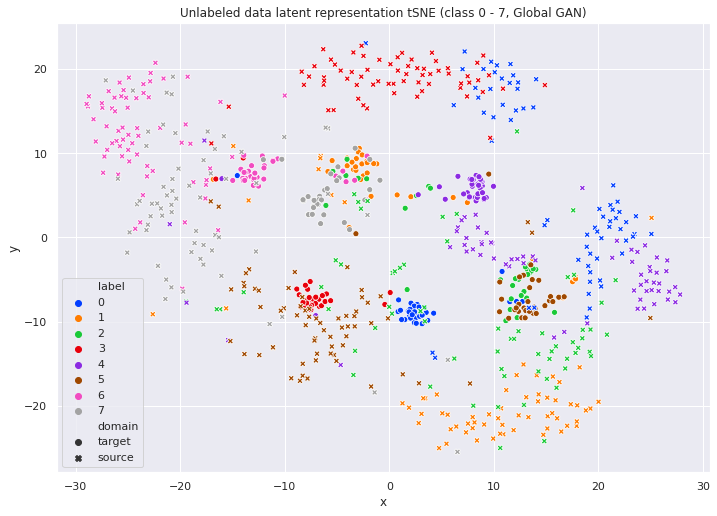

In [28]:
partition=0
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

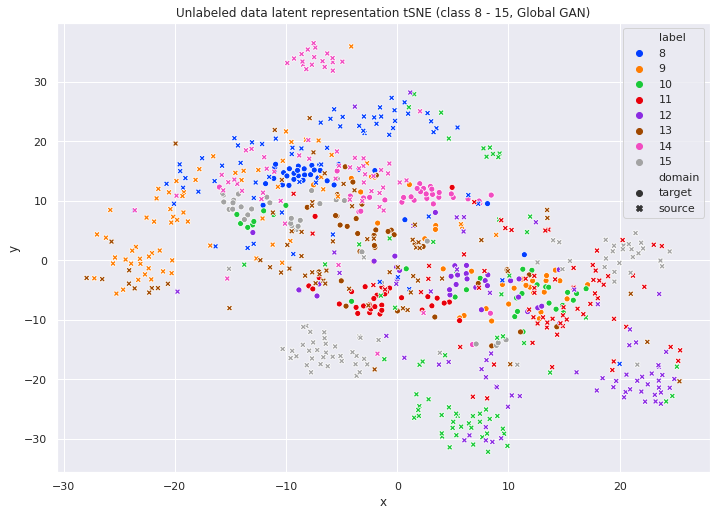

In [29]:
partition=1
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

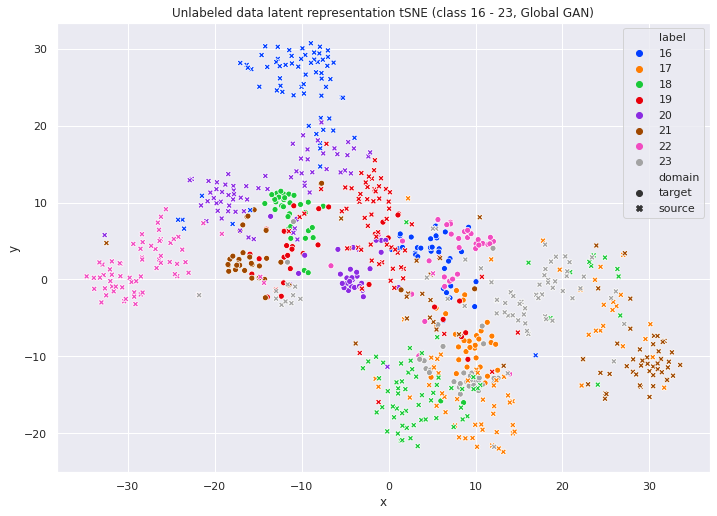

In [30]:
partition=2
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

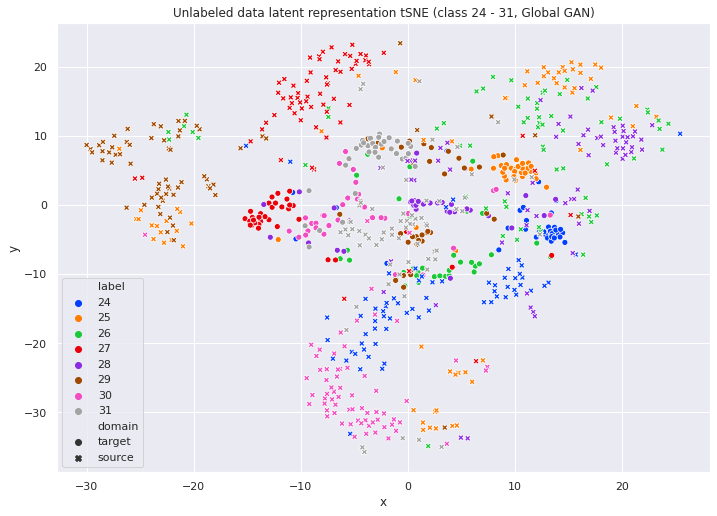

In [31]:
partition=3
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

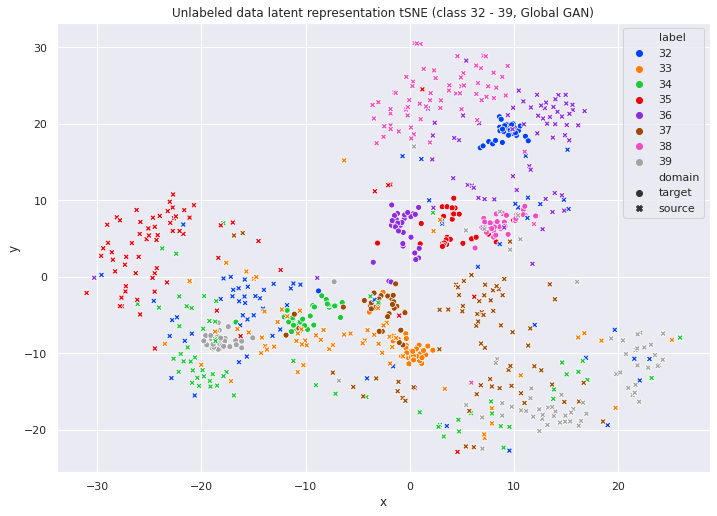

In [32]:
partition=4
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

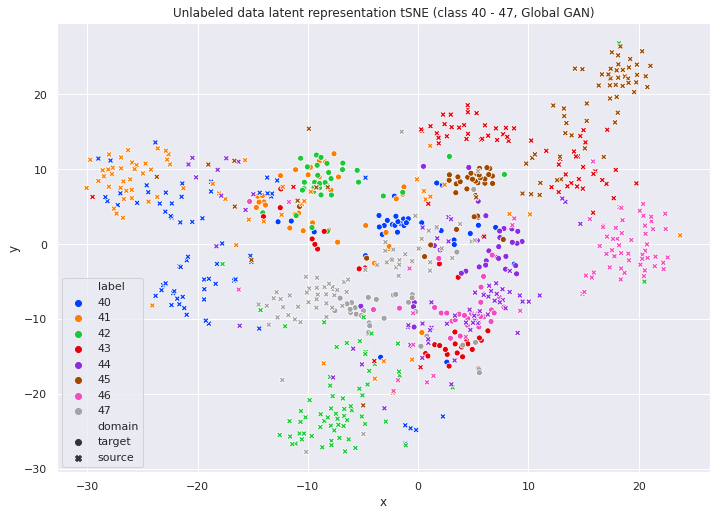

In [33]:
partition=5
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

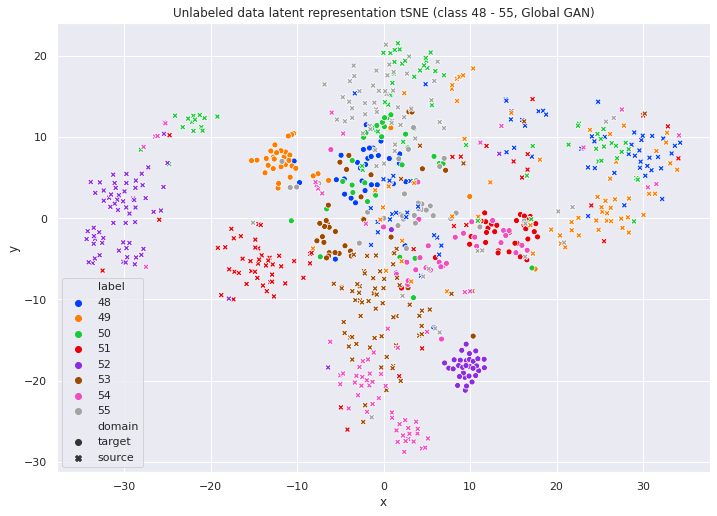

In [34]:
partition=6
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

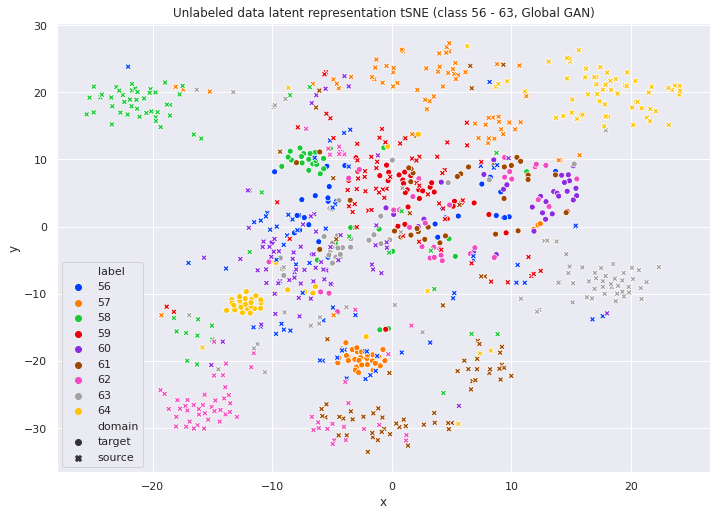

In [35]:
partition=7
title = 'Unlabeled data latent representation tSNE (class {} - {}, Global GAN)'.format(65//8*partition, 65//8*(partition+1)-1)
plot_partition_tSNE(partition, encoder, encoder_MLP, unlabeled_target_x_part, unlabeled_source_x_part, unlabeled_target_y_part,unlabeled_source_y_part, title)

In [37]:
def plot_single_domain_tSNE(domain, encoder, encoder_MLP, GNet, unlabeled_x, unlabeled_y, title):
    # partition = 0
    if domain == 'target':
        target_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.FloatTensor(unlabeled_x).to(device))
        fake_source_embedding_all = GNet(target_x_embedding_all)
        tsne_target = TSNE()
        target_embedded = tsne_target.fit_transform(fake_source_embedding_all.cpu().detach())
        dat = {'x':target_embedded[:,0], 
                       'y': target_embedded[:,1],
                       'label':  unlabeled_y  }

    
    else:
        
    
        source_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.FloatTensor(unlabeled_x).to(device))

        tsne_source = TSNE()
        source_embedded = tsne_source.fit_transform(source_x_embedding_all.cpu().detach())

        dat = {'x':source_embedded[:,0], 
                       'y': source_embedded[:,1],
                       'label':  unlabeled_y  }
    
    dat_pd = pd.DataFrame(data=dat)
    # plot 
    # unlabeled target
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    palette = sns.color_palette("bright", 65)
    g = sns.scatterplot(dat_pd.x, dat_pd.y, hue=dat_pd.label, legend=False, palette=palette)

    plt.title(title)
    return g


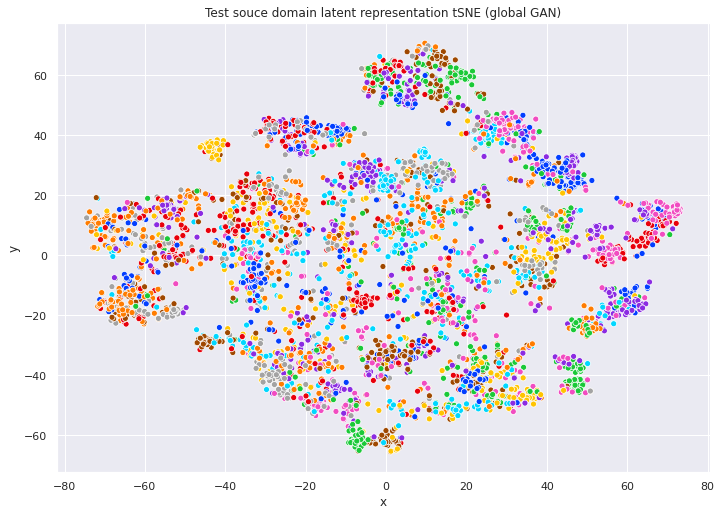

In [40]:
title = "Test souce domain latent representation tSNE (global GAN)"
plot_single_domain_tSNE('source', encoder, encoder_MLP, GNet, unlabeled_source_x, unlabeled_source_y, title)

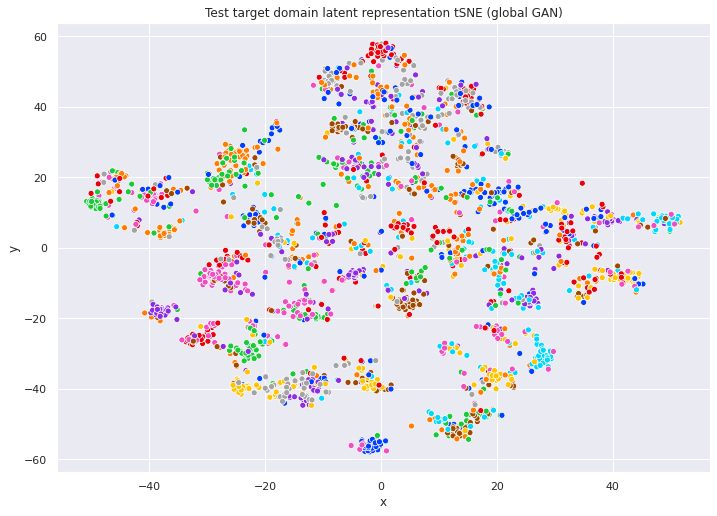

In [41]:
title = "Test target domain latent representation tSNE (global GAN)"
plot_single_domain_tSNE('target', encoder, encoder_MLP, GNet, unlabeled_target_x, unlabeled_target_y, title)